# Fáza 2 - predspracovanie údajov
## Autori: Matej Delinčák (50%), Martin Pirkovský (50%)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import mean
import datetime
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin



pd.set_option("display.max_columns", None)

## 1. Integrácia a čistenie dát (5b)

In [2]:
def load_datasets(filename1, filename2):
    df_profiles = pd.read_csv(filename1, sep='\t', parse_dates=['birthdate'])
    df_profiles.drop('Unnamed: 0', axis=1, inplace=True)
    df_labor = pd.read_csv(filename2, sep='\t')
    df_labor.drop('Unnamed: 0', axis=1, inplace=True)
    return pd.merge(df_profiles,df_labor,on='name',how='outer')

Funkcia load_datasets načíta z dvoch súborov dataset, prvý stĺpec s poradovým číslom vyhodí a parsne dátum do spravného tvaru.

In [3]:
df = load_datasets("001/profiles.csv","001/labor.csv")

In [4]:
## vyhodili sme tieto stlpce: job, residence, birthdate(zamenit za age), ssn_x, current_location, name, ssn_y

def fix_dataset(dataset):
    dataset.replace('no', 'N', inplace=True)
    dataset.replace('yes', 'Y', inplace=True)
    dataset.replace('divoced', 'divorced', inplace=True)
    dataset.replace('black', 'Black', inplace=True)
    dataset.replace('blsck', 'Black', inplace=True)
    dataset.replace('white', 'White', inplace=True)
    dataset["age"] = datetime.datetime.now().year - pd.DatetimeIndex(dataset["birthdate"]).year
    dataset.drop(dataset[dataset.weight < 0].index, inplace=True)
    dataset = dataset.drop(columns=['residence', 'birthdate', 'ssn_x', 'current_location', 'name', 'ssn_y', 'job'])
    dataset.drop_duplicates
    return dataset

Funkcia fix_dataset v datasete upraví rozhádzané hodnoty, aby sme ich neskôr mohli ľahšie použiť. A takisto aj vytvorí stĺpec age.

In [5]:
df = fix_dataset(df)

## Predspracovanie jednotlivych atributov
### Atribut sex

In [6]:
print(len((df[df['sex'].isnull()])))

0


In [7]:
df['sex'].unique()

array(['M', 'F'], dtype=object)

In [8]:
def sanitize_sex(sex):
    return 1 if sex == "M" else 0

In [9]:
df['sex'] = df['sex'].map(lambda x: sanitize_sex(x))

In [10]:
df['sex'].unique()

array([1, 0], dtype=int64)

Atribút sex nemá žiadne null hodnoty, a teda nepotrebujeme riešiť chybajúce hodnoty.
Zamenili sme hodnoty 'M' za 1 a 'F' za 0. Tieto hodnoty nebolo potrebné upravovať,
nakoľko všetky boli v tvare 'M' alebo 'F'.

### Atribut blood_group

In [11]:
print(len((df[df['blood_group'].isnull()])))

0


In [12]:
def sanitize_blood_group(blood_group):
    if blood_group == 'B-':
        return 0
    elif blood_group == 'B+':
        return 1
    elif blood_group == 'AB+':
        return 2
    elif blood_group == 'O+':
        return 3
    elif blood_group == 'AB-':
        return 4
    elif blood_group == 'A-':
        return 5
    elif blood_group == 'O-':
        return 6
    elif blood_group == 'A+':
        return 7
    return blood_group

In [13]:
df['blood_group'] = df['blood_group'].map(lambda x: sanitize_blood_group(x))

In [14]:
df['blood_group'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

### Atribut race

In [15]:
print(len((df[df['race'].isnull()])))

0


In [16]:
def sanitize_race(race):
    if race == 'black' or race == 'blsck' or race == 'Black':
        return 0
    elif race == 'white' or race == 'White':
        return 1
    elif race == 'Indian':
        return 2
    elif race == 'Asian':
        return 3
    elif race == 'Hawaiian':
        return 4
    return race

In [17]:
df['race'] = df['race'].map(lambda race: sanitize_race(race))

In [18]:
df['race'].unique()

array([1, 2, 0, 3, 4], dtype=int64)

### Atribut erytrocyty

In [19]:
print(len((df[df['erytrocyty'].isnull()])))

31


In [20]:
df.dropna(subset = ["erytrocyty"], inplace=True)
print(len((df[df['erytrocyty'].isnull()])))

0


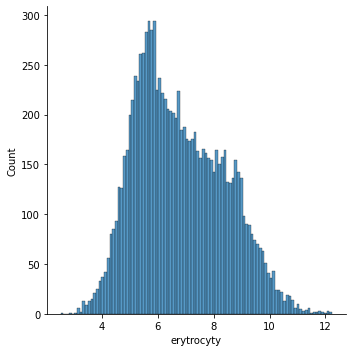

In [21]:
sns.displot(df['erytrocyty'],bins=100)

In [22]:
def identify_outliers(x):
    lower_ = x.quantile(0.25) - 1.5 * stats.iqr(x)
    upper_ = x.quantile(0.75) + 1.5 * stats.iqr(x)

    return x[(x > upper_) | (x < lower_)]

Funkcia identify_outliers vráti z poľa čísel outlierov. Týcho môžme potom ďalej buď vyhodiť alebo nahradiť hodnotami.

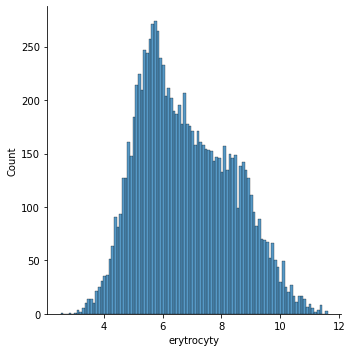

In [23]:
df_merged_out = identify_outliers(df["erytrocyty"])
df = df.drop(df_merged_out.index)
sns.displot(df['erytrocyty'],bins=100)

V atribute eryrocyty sme null hodnoty vyhodili a outlierov sme vyhodili takisto. Na grafoch je vidno, že outliery sú preč.

#### Atribut trombocyty

In [24]:
print(len((df[df['trombocyty'].isnull()])))

31


In [25]:
df['trombocyty'].fillna(df['trombocyty'].mean(), inplace=True)
print(len((df[df['trombocyty'].isnull()])))

0


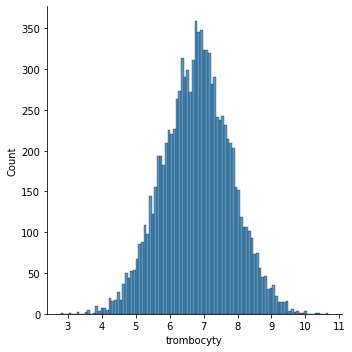

In [26]:
sns.displot(df['trombocyty'],bins=100)

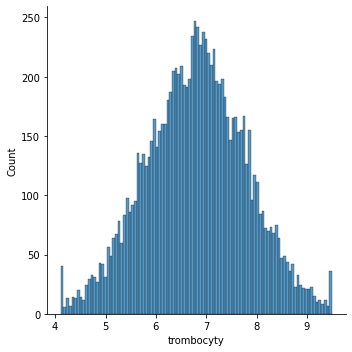

In [27]:
lower = df['trombocyty'].quantile(0.25) - 1.5 * stats.iqr(df['trombocyty'])
upper = df['trombocyty'].quantile(0.75) + 1.5 * stats.iqr(df['trombocyty'])

df["trombocyty"] = np.where(df["trombocyty"] > upper, upper, df['trombocyty'])
df["trombocyty"] = np.where(df["trombocyty"] < lower, lower, df['trombocyty'])
sns.displot(df['trombocyty'],bins=100)

V atribute trombocyty sme nahradili null hodnoty a outliers hranicnymi hodnotami rozdelenia. Na grafoch je vidno, že outliery sú preč.

#### Atribut weight

In [28]:
df["weight"] = np.where(df["weight"] < 1, np.nan, df['weight'])
df.dropna(subset = ["weight"], inplace=True)
print(len((df[df['weight'].isnull()])))

0


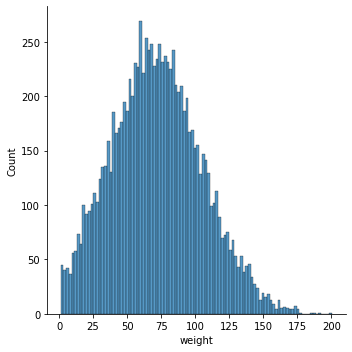

In [29]:
sns.displot(df['weight'],bins=100)

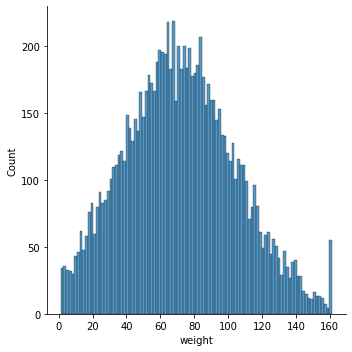

In [30]:
lower = df['weight'].quantile(0.25) - 1.5 * stats.iqr(df['weight'])
upper = df['weight'].quantile(0.75) + 1.5 * stats.iqr(df['weight'])

df["weight"] = np.where(df["weight"] > upper, upper, df['weight'])
df["weight"] = np.where(df["weight"] < lower, lower, df['weight'])
sns.displot(df['weight'],bins=100)

V atribute weight sme odstránili nezmyselné hodnoty (vahy menšie ako 1kg)
a nahradili sme za medián váh. Na grafoch je vidno, že outliery sú preč.

#### Atribut relation

In [31]:
print(len((df[df['relationship'].isnull()])))

0


In [32]:
df.dropna(subset = ["relationship"], inplace=True)
print(len((df[df['relationship'].isnull()])))

0


In [33]:
def sanitize_relation(relationship):
    if relationship == 'divoced' or relationship == 'divorced' :
        return 0
    elif relationship == 'single':
        return 1
    elif relationship == 'married':
        return 2
    elif relationship == 'widowed':
        return 3
    elif relationship == 'separated':
        return 4
    elif relationship == 'nop':
        return 5
    return relationship

In [34]:
df['relationship'] = df['relationship'].map(lambda relation: sanitize_relation(relation))

In [35]:
df['relationship'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

V atribute relationship sme vymazali null hodnoty a zvysne nahradili integer hodnotami (encoding). Na grafoch je vidno, že outliery sú preč.

#### Atribut smoker

In [36]:
print(len((df[df['smoker'].isnull()])))

0


In [37]:
df.dropna(subset = ["smoker"], inplace=True)
print(len((df[df['smoker'].isnull()])))

0


In [38]:
def sanitize_smoker(smoker):
    if smoker == 'N' or smoker == 'no' :
        return 0
    elif smoker == 'Y' or smoker == 'yes':
        return 1
    return smoker

In [39]:
df['smoker'] = df['smoker'].map(lambda smoker: sanitize_smoker(smoker))

In [40]:
df['smoker'].unique()

array([0, 1], dtype=int64)

V atribute smoker sme vymazali null hodnoty a zvysne nahradili integer hodnotami (encoding).

#### Atribut hbver

In [41]:
print(len((df[df['hbver'].isnull()])))

31


In [42]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
print(len((df[df['hbver'].isnull()])))

0


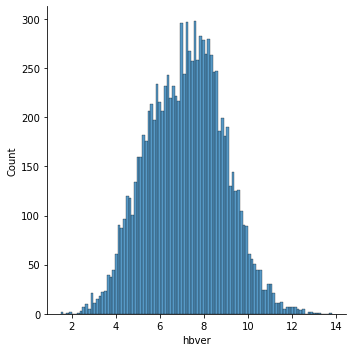

In [43]:
sns.displot(df['hbver'],bins=100)

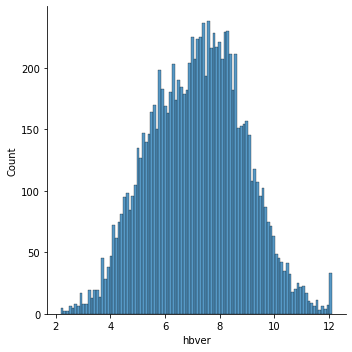

In [44]:
lower = df['hbver'].quantile(0.25) - 1.5 * stats.iqr(df['hbver'])
upper = df['hbver'].quantile(0.75) + 1.5 * stats.iqr(df['hbver'])

df["hbver"] = np.where(df["hbver"] > upper, upper, df['hbver'])
df["hbver"] = np.where(df["hbver"] < lower, lower, df['hbver'])
sns.displot(df['hbver'],bins=100)

V atribute hbver a v podstate celom datasete sme nahradili null hodnoty pomocou KNN algoritmu, cize dalej null hodnoty uz nebudeme riesit. A outlierov sme zase ustrihli a nahradili krajnymi hodnotami.

#### Atribut er-cv

In [45]:
print(len((df[df['er-cv'].isnull()])))

0


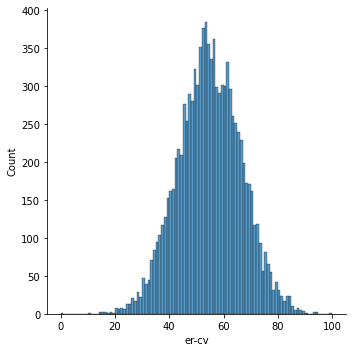

In [46]:
sns.displot(df['er-cv'],bins=100)

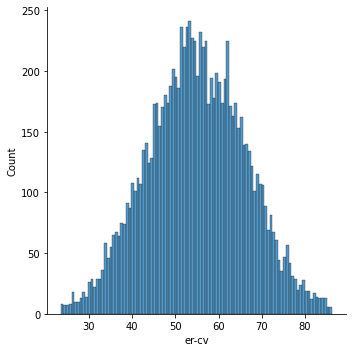

In [47]:
def identify_outliers(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    lower_ = x.quantile(0.25) - 1.5 * iqr
    upper_ = x.quantile(0.75) + 1.5 * iqr

    return x[(x > upper_) | (x < lower_)]

df_merged_out = identify_outliers(df["er-cv"])
df = df.drop(df_merged_out.index)
sns.displot(df['er-cv'],bins=100)

V atribute er-cv sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.


#### Atribut hematokrit

In [48]:
print(len((df[df['hematokrit'].isnull()])))

0


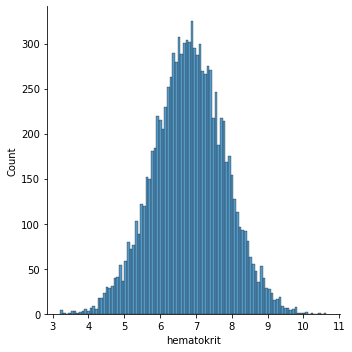

In [49]:
sns.displot(df['hematokrit'],bins=100)

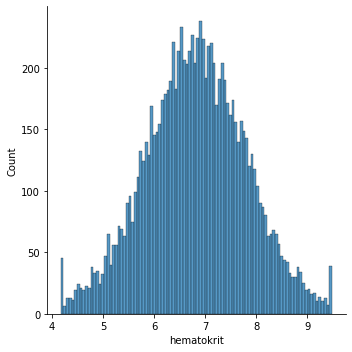

In [50]:
lower = df['hematokrit'].quantile(0.25) - 1.5 * stats.iqr(df['hematokrit'])
upper = df['hematokrit'].quantile(0.75) + 1.5 * stats.iqr(df['hematokrit'])

df["hematokrit"] = np.where(df["hematokrit"] > upper, upper, df['hematokrit'])
df["hematokrit"] = np.where(df["hematokrit"] < lower, lower, df['hematokrit'])
sns.displot(df['hematokrit'],bins=100)

V atribute hematokrit sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

#### Atribut leukocyty

In [51]:
print(len((df[df['leukocyty'].isnull()])))

0


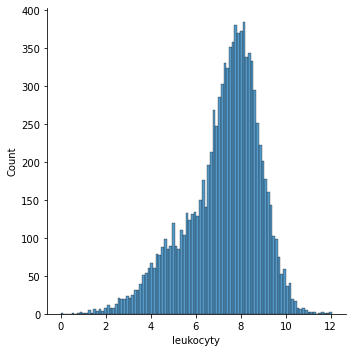

In [52]:
sns.displot(df['leukocyty'],bins=100)

In [53]:
def identify_outliers(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    lower_ = x.quantile(0.25) - 1.5 * iqr
    upper_ = x.quantile(0.75) + 1.5 * iqr

    return x[(x > upper_) | (x < lower_)]

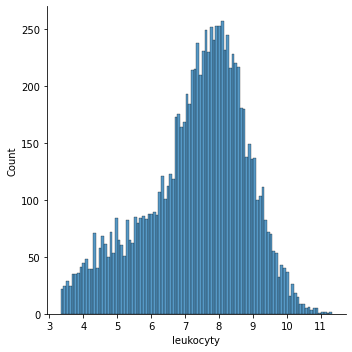

In [54]:
df_merged_out = identify_outliers(df["leukocyty"])
df = df.drop(df_merged_out.index)
sns.displot(df['leukocyty'],bins=100)

V atribute leukocyty sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut alp

In [55]:
print(len((df[df['alp'].isnull()])))

0


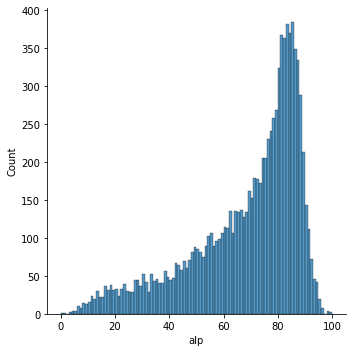

In [56]:
sns.displot(df['alp'],bins=100)

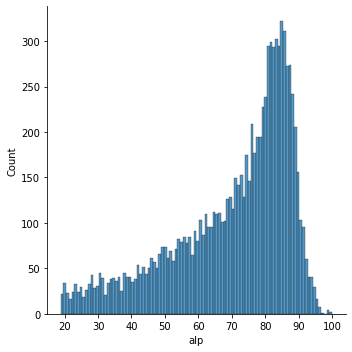

In [57]:
df_merged_out = identify_outliers(df["alp"])
df = df.drop(df_merged_out.index)
sns.displot(df['alp'],bins=100)

V atribute alp sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.


#### Atribut hemoglobin

In [58]:
print(len((df[df['hemoglobin'].isnull()])))

0


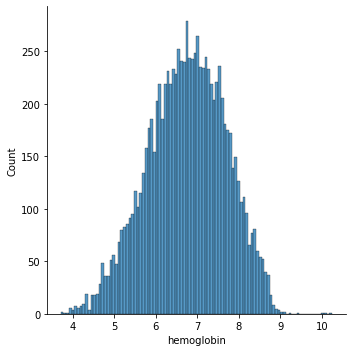

In [59]:
sns.displot(df['hemoglobin'],bins=100)

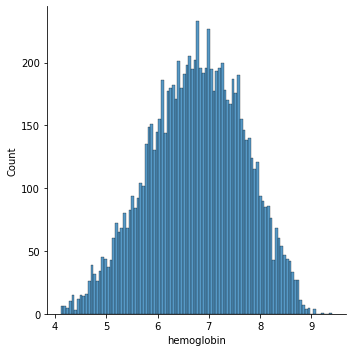

In [60]:
df_merged_out = identify_outliers(df["hemoglobin"])
df = df.drop(df_merged_out.index)
sns.displot(df['hemoglobin'],bins=100)

V atribute hemoglobin sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut ast

In [61]:
print(len((df[df['ast'].isnull()])))

0


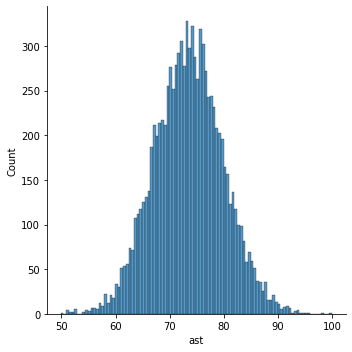

In [62]:
sns.displot(df['ast'],bins=100)

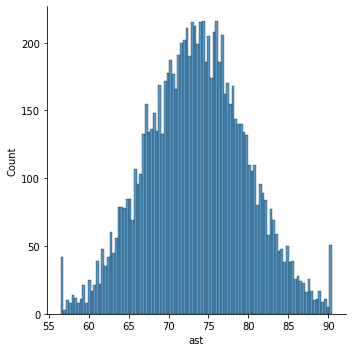

In [63]:
lower = df['ast'].quantile(0.25) - 1.5 * stats.iqr(df['ast'])
upper = df['ast'].quantile(0.75) + 1.5 * stats.iqr(df['ast'])

df["ast"] = np.where(df["ast"] > upper, upper, df['ast'])
df["ast"] = np.where(df["ast"] < lower, lower, df['ast'])
sns.displot(df['ast'],bins=100)

V atribute ast sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

#### Atribut alt

In [64]:
print(len((df[df['alt'].isnull()])))

0


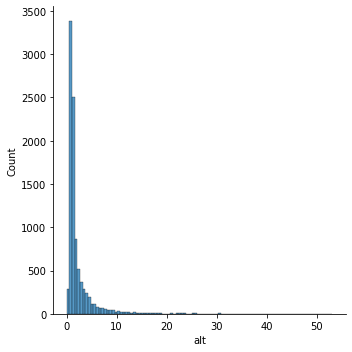

In [65]:
sns.displot(df['alt'],bins=100)

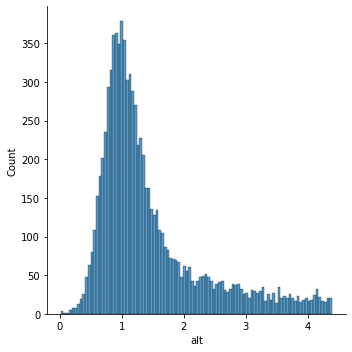

In [66]:
df_merged_out = identify_outliers(df["alt"])
df = df.drop(df_merged_out.index)
sns.displot(df['alt'],bins=100)

V atribute alt sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut etytr

In [67]:
print(len((df[df['etytr'].isnull()])))

0


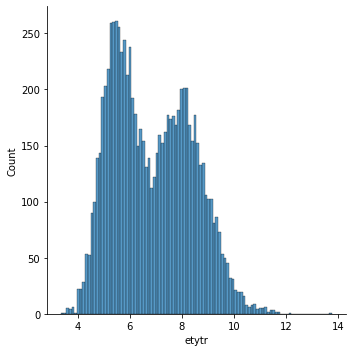

In [68]:
sns.displot(df['etytr'],bins=100)

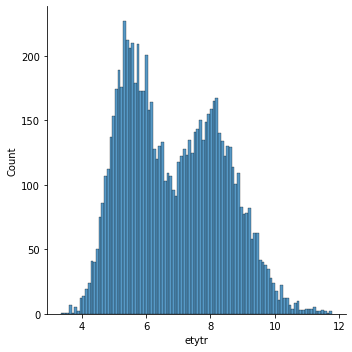

In [69]:
df_merged_out = identify_outliers(df["etytr"])
df = df.drop(df_merged_out.index)
sns.displot(df['etytr'],bins=100)

V atribute etytr sme uz teda nepotrebovali odstranovat null lebo knn. Outlierov sme odstranili pre zmenu.

#### Atribut ast

In [70]:
print(len((df[df['age'].isnull()])))

0


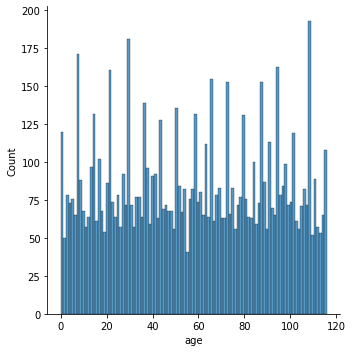

In [71]:
sns.displot(df['age'],bins=100)

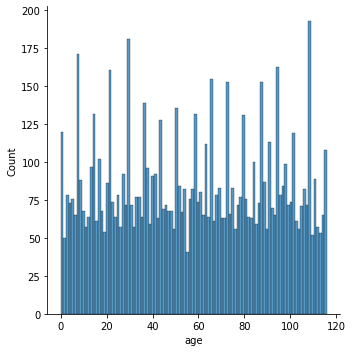

In [72]:
lower = df['age'].quantile(0.25) - 1.5 * stats.iqr(df['age'])
upper = df['age'].quantile(0.75) + 1.5 * stats.iqr(df['age'])

df["age"] = np.where(df["age"] > upper, upper, df['age'])
df["age"] = np.where(df["age"] < lower, lower, df['age'])
sns.displot(df['age'],bins=100)

V atribute age sme uz nepotrebovali odstranovat null lebo KNN. Outlierov sme nahradili krajnými hodnotami.

## Zhodnotenie

Pre každý atribút sme zistili či má nejaké null hodnoty. Ak má tak sme ich niekedy vyhodili a niekedy nahradili hodnotou mean. Na polku datasetu sme použili KNN algoritmus na nahradenie null hodnôt. Je to preto, aby sme skúsili a ukázali, že to vieme :). Podobne sme aj odstráňovali outlierov a to tak, že buď sme ich vyhodili alebo nahradili krajnými hodnotami rozdelenia.

### 2. Realizácia predspracovania dát (5b)

Rozhodli sme sa rozdeliť dataset na 15% pre testovacie dáta a 85% na trénovacie dáta. Ďalej sa bude teda spracovávať len trénovacia vzorka.

In [73]:
df_train, df_test = train_test_split(df, test_size=0.15)

In [74]:
columns = ['erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']
features = df_train[columns]

In [75]:
scaler = MinMaxScaler()
df_train[columns] = scaler.fit_transform(df_train[columns])

C:\Users\matej\AppData\Local\Temp/ipykernel_11452/1287593276.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_train.hist(ax = ax)


array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'relationship'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

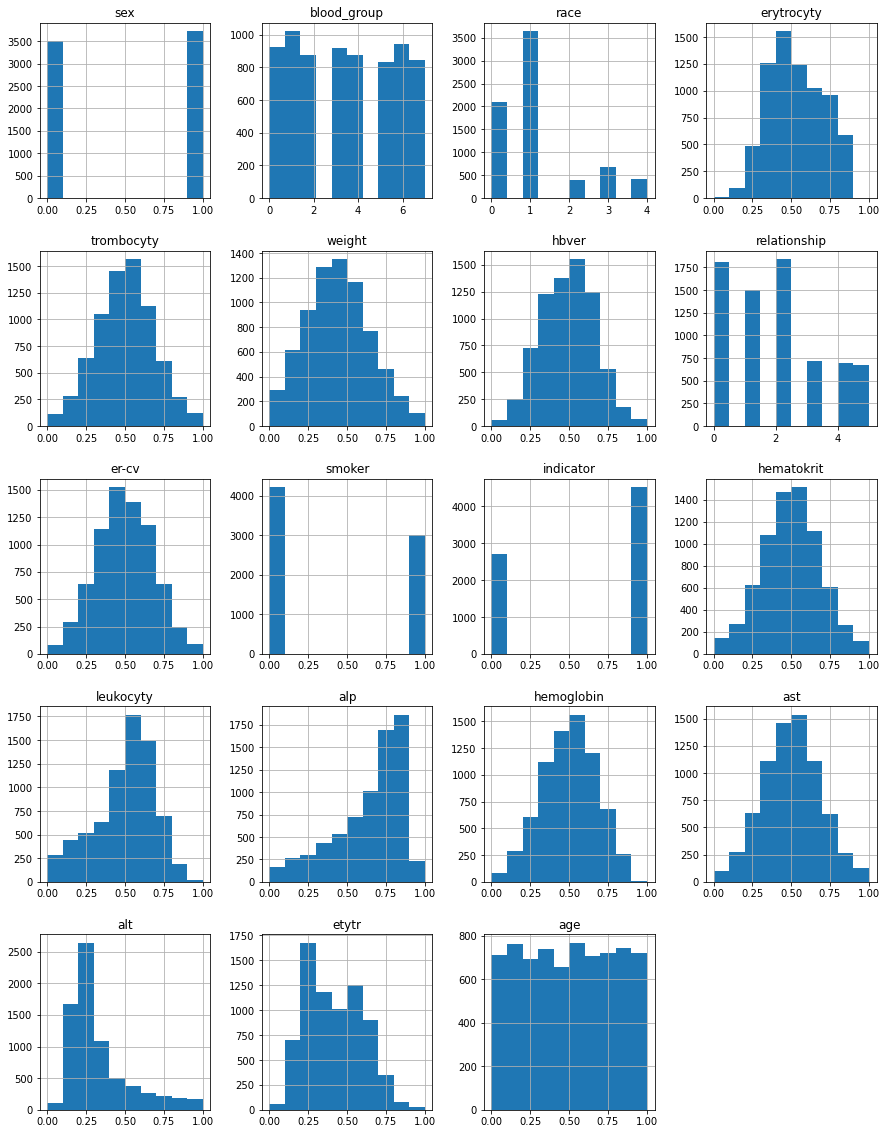

In [76]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_train.hist(ax = ax)

In [77]:
transformer = PowerTransformer(method = 'yeo-johnson')
df_train[columns] = transformer.fit_transform(features.values)

C:\Users\matej\AppData\Local\Temp/ipykernel_11452/1287593276.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_train.hist(ax = ax)


array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'blood_group'}>,
        <AxesSubplot:title={'center':'race'}>,
        <AxesSubplot:title={'center':'erytrocyty'}>],
       [<AxesSubplot:title={'center':'trombocyty'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'hbver'}>,
        <AxesSubplot:title={'center':'relationship'}>],
       [<AxesSubplot:title={'center':'er-cv'}>,
        <AxesSubplot:title={'center':'smoker'}>,
        <AxesSubplot:title={'center':'indicator'}>,
        <AxesSubplot:title={'center':'hematokrit'}>],
       [<AxesSubplot:title={'center':'leukocyty'}>,
        <AxesSubplot:title={'center':'alp'}>,
        <AxesSubplot:title={'center':'hemoglobin'}>,
        <AxesSubplot:title={'center':'ast'}>],
       [<AxesSubplot:title={'center':'alt'}>,
        <AxesSubplot:title={'center':'etytr'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

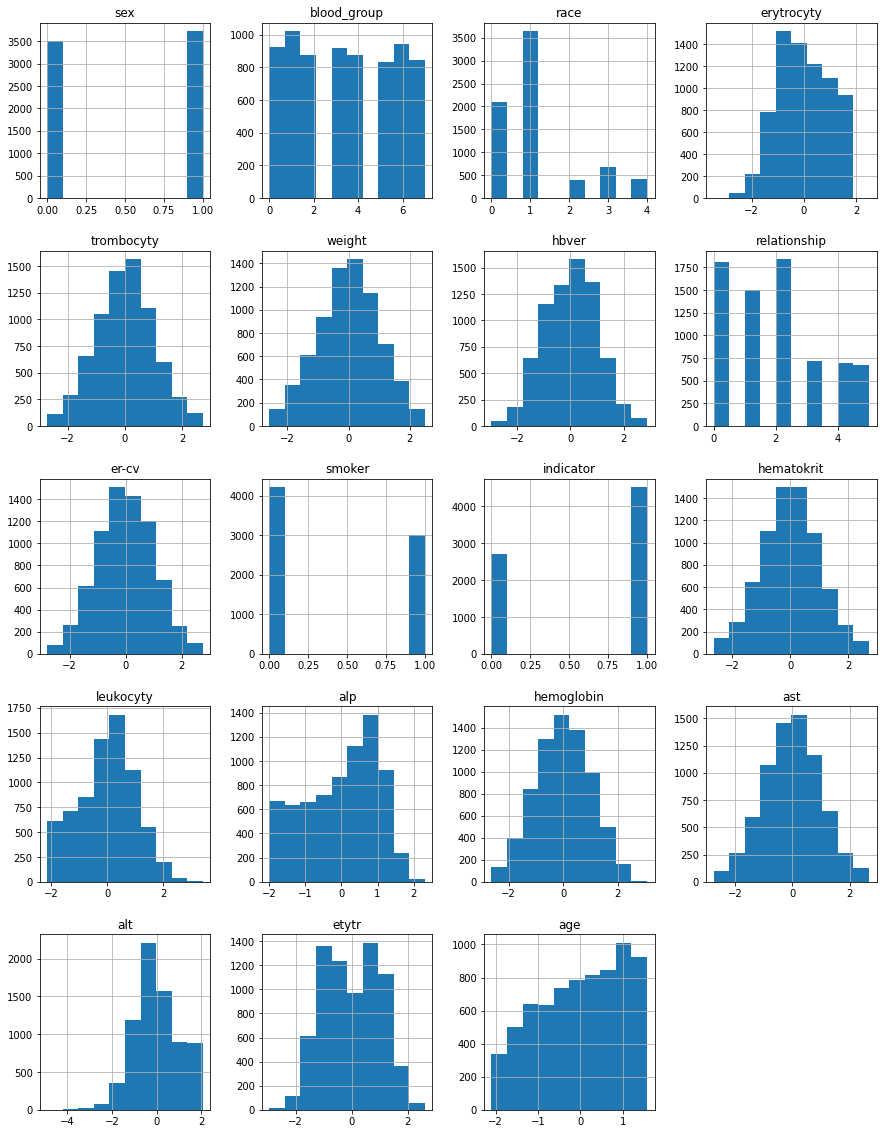

In [78]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_train.hist(ax = ax)

## Zhodnotenie

Na celý dataset (okrem kategorických hodnôt - tie sme nechceli upravovať) sme použili dve techniky na transformáciu dát. Jedna bola MixMaxScaler, ktorá ako vidíme na prvom histograme, naškáluje hodnoty na hodnoty od nula po jedna. Ako druhú techniku sme si skúsili metódu yeo-johnson a ta ako vidíme pozmenila rozdelenia tak, aby ich stred bol v bode nula. Táto technika nám zvláštne upravila atribút age a preto neskôr budeme používať len MixMaxScaler.

## 3. Výber atribútov pre strojové učenie (5b)

Trenovaci dataset sme si rozdelili na kategoricke a numericke hodnoty. Na každú skupinu použijeme iný výber features.

In [79]:
feature_cols = ['sex', 'blood_group', 'race', 'relationship', 'smoker', 'erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']
output_cols = ['indicator']

In [80]:
def split_dataset(dataset):
    global feature_cols
    global output_cols
    
    X = dataset[feature_cols].values
    y = dataset[output_cols].values
    return X, y

Funkcia split_dataset nám rozdelí pandas dataframe na dve matice vstupných a výstupných hodnôt. 

In [81]:
X_train, y_train = split_dataset(df_train)
X_test, y_test = split_dataset(df_test)

C:\Users\matej\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature hbver: 1014.923540
Feature leukocyty: 760.330598
Feature etytr: 110.797189
Feature erytrocyty: 6.046152
Feature hematokrit: 3.954595
Feature smoker: 3.097646
Feature er-cv: 1.181868
Feature weight: 1.054876
Feature alt: 1.047073
Feature sex: 0.900410
Feature race: 0.603363
Feature hemoglobin: 0.594037
Feature trombocyty: 0.558743
Feature alp: 0.374682
Feature age: 0.263642
Feature relationship: 0.110514
Feature ast: 0.084382
Feature blood_group: 0.076880


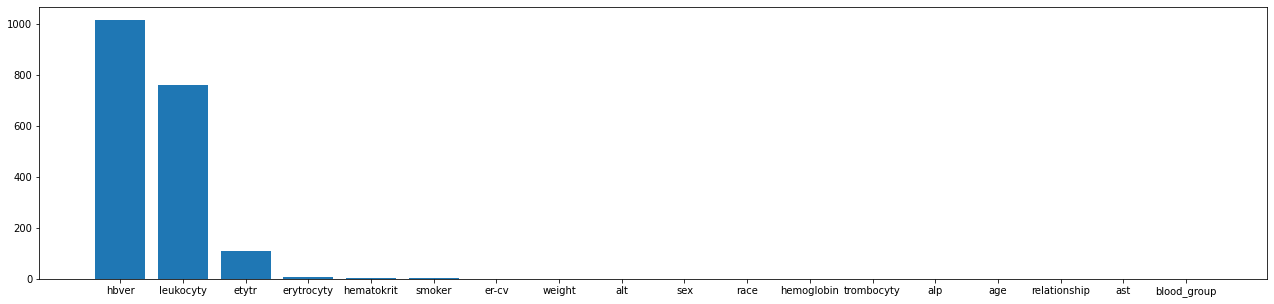

In [82]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

dictX = {}
for i in range(len(fs.scores_)):
    dictX[i] = fs.scores_[i]
    
dictX = dict(sorted(dictX.items(), key=lambda item: item[1], reverse=True))

for i in dictX:
    print('Feature %s: %f' % (feature_cols[i], dictX[i]))

plt.subplots(figsize=(22,5))
plt.bar([feature_cols[x] for x in dictX.keys()], dictX.values())
plt.show()

## Zhodnotenie

Na celej trénovacej množine sme predviedli techniku ANOVA na klasifikáciu, ktorá nám ohodnotila silu jednotlivých atribútov a pomocou SelectKBest sme v tejto časti vybrali všetky, aby sme ich mohli ukázať na grafe. A teda na grafe môžeme vidieť, že práve tri atribúty vyzerajú byť najdôležitejšie a to hbver, leukocyty a etytr. V ďalšej časti zostrojíme program, ktorý nám určí aký počet z týchto atribútov je vhodný na čo najlepšiu presnosť modelu.

## 4. Replikovateľnosť predspracovania (5b)

In [83]:
df = load_datasets("001/profiles.csv","001/labor.csv")
df = fix_dataset(df)

Znova sme si načítali dataset a rýchlo ho upravili.

In [84]:
class CustomEncoderTransformer(TransformerMixin):
    def __init__(self, column_names= [], categorical_cols=[]):
        self.column_names = column_names
        self.categorical_cols = categorical_cols
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        enc = OrdinalEncoder()
        X[self.categorical_cols] = enc.fit_transform(X[self.categorical_cols])
        return X

Náš vlastný encoder, ktorý z datasetu pre všetky predom definované atribúty, vytvorí kódovanie, čím sa zbavíme nečiselných hodnôt.

In [85]:
class CustomOutlierTransformer(TransformerMixin):
    def __init__(self, column_names= [], strategy="drop"):
        self.column_names = column_names
        self.strategy = strategy;
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        for column in X.columns:
            df_merged_out = identify_outliers(X[column])
            if (self.strategy == "drop"):
                X = X.drop(df_merged_out.index)
            elif (self.strategy == "mean"):
                X[column].fillna(X[column].mean(), inplace=True)

        return X
    
    def identify_outliers(x):
        iqr = x.quantile(0.75) - x.quantile(0.25)
        lower_ = x.quantile(0.25) - 1.5 * iqr
        upper_ = x.quantile(0.75) + 1.5 * iqr

        return x[(x > upper_) | (x < lower_)]

Náš vlastný outlier detection mechanizmus, ktorý z datasetu pre všetky atribúty, buď zahodí outlierov alebo ich nahradí meanom. Závisí od zvolenej stratégie.

In [86]:
class CustomMinMaxTransformer(TransformerMixin):
    def __init__(self, column_names= [], numerical_cols=[]):
        self.column_names = column_names
        self.numerical_cols = numerical_cols
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        scaler = MinMaxScaler()
        X[self.numerical_cols] = scaler.fit_transform(X[self.numerical_cols])
        return X

Náš vlastný outlier detection mechanizmus, ktorý z datasetu pre všetky číselné atribúty použije MinMaxScaler.

In [87]:
class CustomKnnForNullValuesTransformer(TransformerMixin):
    def __init__(self, column_names= []):
        self.column_names = column_names
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        imputer = KNNImputer(n_neighbors=5)
        X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
        return X

Náš vlastný transformer, ktorý pomocou KNN algoritmu odstraní všetky null hodnoty z datasetu.

In [88]:
class DfToValuesOnlyTransformer(TransformerMixin):
    def __init__(self, column_names= [], feature_cols=[], output_cols=[]):
        self.column_names = column_names
        self.feature_cols = feature_cols
        self.output_cols = output_cols
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.column_names)
        X, y = split_dataset(X)
        return X, y
    
    def split_dataset(dataset):
        X = dataset[self.feature_cols].values
        y = dataset[self.output_cols].values
        return X, y

Náš vlastný transformer, ktorý z datasetu urobí dve polia vstupných a výstupnych atribútov.

In [89]:
feature_cols = ['sex', 'blood_group', 'race', 'relationship', 'smoker', 'erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']
output_cols = ['indicator']
categorical_cols = ['sex', 'blood_group', 'race', 'relationship', 'smoker']
numerical_cols = ['erytrocyty', 'trombocyty', 'weight', 'hbver', 'er-cv', 'hematokrit', 'leukocyty', 'alp', 'hemoglobin', 'ast', 'alt', 'etytr', 'age']

encoder = CustomEncoderTransformer(df.columns, categorical_cols)
outlier = CustomOutlierTransformer(df.columns)
minmax = CustomMinMaxTransformer(df.columns, numerical_cols)
nulls = CustomKnnForNullValuesTransformer(df.columns)
split = DfToValuesOnlyTransformer(df.columns, feature_cols, output_cols)

my_pipeline = make_pipeline(encoder, nulls, outlier, minmax, split)
X, y = my_pipeline.fit_transform(df)


Pomocou pipeline, ktorú sme poskladali z našich tranformerov, sme z datasetu spravili už upravený dataset. Všetko čo sme robii doteraz v predspracovaní, sme zvládli urobiť znova v tejto bunke. Pipeline nám dala už aj rozdelený dataset na vstupné a výstupné atribúty a tie hneď použijeme v ďalšej pipeline.

In [90]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

num_features = [i+1 for i in range(X.shape[1])]
results = list()
for k in num_features:

    model = LogisticRegression(solver='liblinear')
    fs = SelectKBest(score_func=f_classif, k=k)

    pipeline = Pipeline(steps=[('anova',fs), ('liblinear', model)])

    scores = evaluate_model(pipeline, X, y)
    results.append(scores)

    print('Počet vybraných atribútov: %d, Accuracy score: %.3f ' % (k, mean(scores)))
    


Počet vybraných atribútov: 1, Accuracy score: 0.648 
Počet vybraných atribútov: 2, Accuracy score: 0.795 
Počet vybraných atribútov: 3, Accuracy score: 0.792 
Počet vybraných atribútov: 4, Accuracy score: 0.791 
Počet vybraných atribútov: 5, Accuracy score: 0.790 
Počet vybraných atribútov: 6, Accuracy score: 0.791 
Počet vybraných atribútov: 7, Accuracy score: 0.791 
Počet vybraných atribútov: 8, Accuracy score: 0.791 
Počet vybraných atribútov: 9, Accuracy score: 0.792 
Počet vybraných atribútov: 10, Accuracy score: 0.791 
Počet vybraných atribútov: 11, Accuracy score: 0.792 
Počet vybraných atribútov: 12, Accuracy score: 0.792 
Počet vybraných atribútov: 13, Accuracy score: 0.791 
Počet vybraných atribútov: 14, Accuracy score: 0.791 
Počet vybraných atribútov: 15, Accuracy score: 0.791 
Počet vybraných atribútov: 16, Accuracy score: 0.791 
Počet vybraných atribútov: 17, Accuracy score: 0.791 
Počet vybraných atribútov: 18, Accuracy score: 0.791 


Ako môžme vidieť, pomocou RepeatedStratifiedKFold a cross_val_score, sme zistili, že najväčšiu presnosť dosahujeme pre počet atribútov 2. A zistili sme, že najväčšiu dôležitosť mali atribúty hbver a leukocyty. Tento cyklus prešiel všetky najlepšie atribúty a postupne bral viac a viac atribútov pomocou SelectKBest a ohodnocovacej stratégie ANOVA.